# Transformers - Arquitectura

Análisis de la arquitectura _Transformer_ propuesta originalmente en el _paper_ seminal "_Attention Is All You Need_".

## 1. Transformer

Un _transformer_ es un modelo de red neuronal que procesa una secuencia de entrada y genera una secuencia de salida.

```
Input ─> Output
```

### 1.1. Encoder-Decoder

El modelo tiene dos componentes.

```
Input ─> Encoder ─> Decoder ─> Output
```

El _encoder_ procesa la secuencia de entrada capturando las relaciones entre sus elementos.

El _decoder_ produce la secuencia de salida, elemento a elemento, apoyándose en la información capturada por el encoder y los propios elementos que va generando.

La arquitectura fue desarrollada originalmente en el ámbito del procesamiento del lenguaje natural para la traducción de textos de un idioma a otro. Es habitual entenderla como una red neuronal que procesa un texto y genera otro, palabra a palabra.

## 2. Vocabulary

La red trabaja con un vocabulario de $V$ elementos distintos. Donde cada elemento del vocabulario se conoce como _token_.

$ \begin{array}{c|l}
\text{Token} & \text{Word} \\ \hline
1 & \text{casa} \\
2 & \text{árbol} \\
3 & \text{mesa} \\
\vdots & \vdots \\
V & \text{perro} \\
\end{array} $

Cada _token_ se representa mediante un _embedding_. Un _embedding_ es un vector numérico de tamaño $d$.

$ \begin{array}{c|l|l}
\text{Token} & \text{Word} & \text{Embedding} \\ \hline
1 & \text{casa} & [e^1_1, e^1_2, \ldots, e^1_d] \\
2 & \text{árbol} & [e^2_1, e^2_2, \ldots, e^2_d] \\
3 & \text{mesa} & [e^3_1, e^3_2, \ldots, e^3_d] \\
\vdots & \vdots & \vdots \\
V & \text{perro} & [e^V_1, e^V_2, \ldots, e^V_d] \\
\end{array} $

En el _paper_ original los _embeddings_ tienen un tamaño de 512.

## 3. Input

La entrada a la red es una secuencia de _tokens_ de longitud $n$.

Por convención, una secuencia de entrada $X$ se representa como una matriz de $n$ filas por $d$ columnas, donde cada fila corresponde a un _token_ distinto.

- $ X = \begin{bmatrix}
x_{1,1} & x_{1,2} & \ldots & x_{1,d}
\\ x_{2,1} & x_{2,2} & \ldots & x_{2,d}
\\ \vdots & \vdots & \ddots & \vdots
\\ x_{n,1} & x_{n,2} & \ldots & x_{n,d}
\end{bmatrix} $

Dimensiones:

- $ X \in \mathbb{R}^{n \times d} $

### 3.1. Positional Encoding (PE)

Antes de introducir los _embeddings_ en el encoder, se enriquecen con información que depende de la posición relativa que ocupan dentro de la secuencia de entrada.

```
Input ─> Positional Encoding ─> Encoder ─> Decoder ─> Output
```

Se aplica una función $\operatorname{PE}(i, j)$ que se evalúa para cada par $(i, j)$ donde $i = 0, 1, \ldots, n - 1$ y $j = 0, 1, \ldots, d - 1$.

Si $j$ es par se aplica una función seno, y si es impar una función coseno.

- $ \operatorname{PE}(i, j) = \begin{cases} 
\sin\left( \dfrac{i}{10000^{j/d}} \right), & \text{si } j \text{ es par} \\
\cos\left( \dfrac{i}{10000^{(j-1)/d}} \right), & \text{si } j \text{ es impar}
\end{cases} $

Por convención, se considera que los índices empiezan por cero, en vez de por uno como suele ser habitual en la notación matemática.

La función no depende del contenido de la entrada, sólo de la posición de los _tokens_ y el tamaño de los _embeddings_.

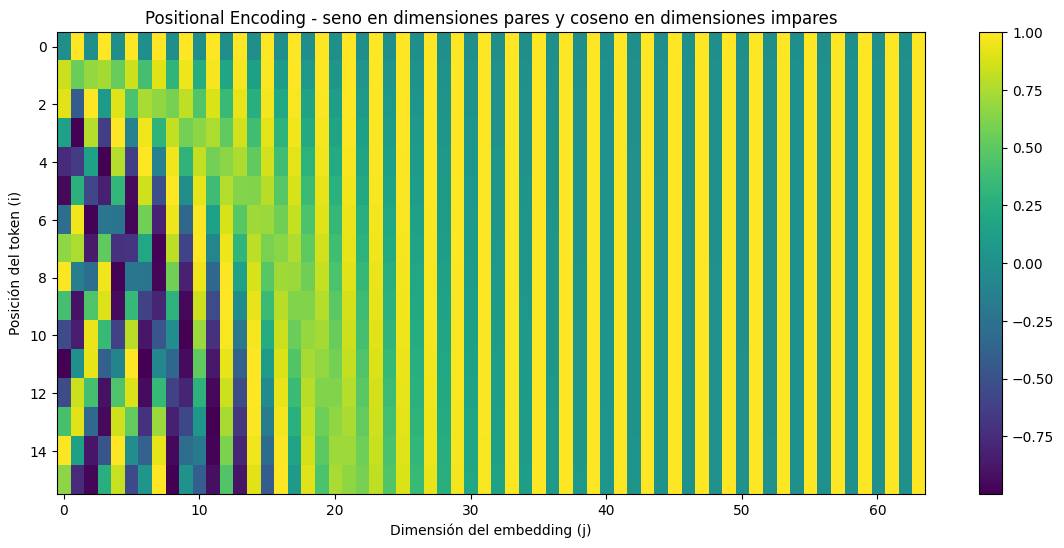

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def draw_positional_encoding():
  n = 16
  d = 64

  i = np.arange(n)[:, np.newaxis]
  j = np.arange(d)[np.newaxis, :]

  PE = np.zeros((n, d))
  PE[:, 0::2] = np.sin(i / 10000**(j[:, 0::2]/d))
  PE[:, 1::2] = np.cos(i / 10000**((j[:, 1::2] - 1)/d))

  plt.figure(figsize=(14, 6))
  im = plt.imshow(PE, aspect='auto')
  plt.xlabel("Dimensión del embedding (j)")
  plt.ylabel("Posición del token (i)")
  plt.title("Positional Encoding - seno en dimensiones pares y coseno en dimensiones impares")
  plt.colorbar(im)
  plt.show()

draw_positional_encoding()

La gráfica muestra que a cada _token_ se le asigna un patrón de valores único en función de su posición dentro de la secuencia de entrada. A mayor distancia entre _tokens_, mayor variación del patrón.

Los _tokens_ en posiciones cercanas comparten patrones similares en sus primeras dimensiones, lo que permite capturar relaciones locales, como por ejemplo que dos _tokens_ (palabras) se presentan habitualmente juntos en una secuencia (frase). Por su parte, los _tokens_ en posiciones alejadas tienen patrones similares sólo en sus últimas dimensiones, lo que permite capturar relaciones globales, como la estructura general de una secuencia.

Para enriquecer la secuencia de entrada con esta información, a los _embeddings_ de entrada se le suman los valores de la función, elemento a elemento.

- $ E^1 = X + \operatorname{PE(i, j)} = \begin{bmatrix}
x_{1,1} & x_{1,2} & \ldots & x_{1,d}
\\ x_{2,1} & x_{2,2} & \ldots & x_{2,d}
\\ \vdots & \vdots & \ddots & \vdots
\\ x_{n,1} & x_{n,2} & \ldots & x_{n,d}
\end{bmatrix} + \begin{bmatrix}
\operatorname{PE}(0, 0) & \operatorname{PE}(0, 1) & \ldots & \operatorname{PE}(0, d-1)
\\ \operatorname{PE}(1, 0) & \operatorname{PE}(1, 1) & \ldots & \operatorname{PE}(1, d-1)
\\ \vdots & \vdots & \ddots & \vdots
\\ \operatorname{PE}(n - 1, 0) & \operatorname{PE}(n - 1, 1) & \ldots & \operatorname{PE}(n - 1, d - 1)
\end{bmatrix}, \quad \text{para } i = 0, \ldots, n-1, j = 0, \dots, d-1 $

Esta información añadida enriquece los valores transportados por la secuencia de entrada, información que se propaga junto con la señal original a través de la red, y queda accesible para todas las capas de la misma.

Dimensiones:

- $ X \in \mathbb{R}^{n \times d} $

- $ E^1 \in \mathbb{R}^{n \times d} $

## 4. Encoder

El encoder se compone de varias capas.

```
Input ─> Positional Encoding ─> Multi-Head Attention ─> Add ─> Norm ─> Feed Forward ─> Add ─> Norm ─> Decoder ─> Output
                             │                           ↑          │                   ↑
                             └───────────────────────────┘          └───────────────────┘
```

### 4.1. Scaled Dot-Product Attention

La primera capa del encoder utiliza el mecanismo de _atención_, por lo que es necesario realizar una breve introducción a dicho mecanismo.

Esta técnica permite capturar relaciones complejas entre los _tokens_ de una secuencia.

Utiliza tres matrices de pesos, $W_Q$, $W_K$, y $W_V$, inicializadas y actualizadas durante el entrenamiento de la red neuronal.

Las matrices son cuadradas, con tantas filas y columnas como dimensiones $d$ tengan los _embeddings_. 

- $ W_Q = \begin{bmatrix}
wq_{1,1} & wq_{1,2} & \ldots & wq_{1,d}
\\ wq_{2,1} & wq_{2,2} & \ldots & wq_{2,d}
\\ \vdots & \vdots & \ddots & \vdots
\\ wq_{d,1} & wq_{d,2} & \ldots & wq_{d,d}
\end{bmatrix} $

- $ W_K = \begin{bmatrix}
wk_{1,1} & wk_{1,2} & \ldots & wk_{1,d}
\\ wk_{2,1} & wk_{2,2} & \ldots & wk_{2,d}
\\ \vdots & \vdots & \ddots & \vdots
\\ wk_{d,1} & wk_{d,2} & \ldots & wk_{d,d}
\end{bmatrix} $

- $ W_V = \begin{bmatrix}
wv_{1,1} & wv_{1,2} & \ldots & wv_{1,d}
\\ wv_{2,1} & wv_{2,2} & \ldots & wv_{2,d}
\\ \vdots & \vdots & \ddots & \vdots
\\ wv_{d,1} & wv_{d,2} & \ldots & wv_{d,d}
\end{bmatrix} $

La matriz de entrada $E^1$ se multiplica (proyecta) por cada una de las matrices de pesos para obtener tres nuevas matrices, $Q$, $K$, y $V$.

- $ Q = E^1 W_Q = \begin{bmatrix}
e^1_{1,1} & e^1_{1,2} & \ldots & e^1_{1,d}
\\ e^1_{2,1} & e^1_{2,2} & \ldots & e^1_{2,d}
\\ \vdots & \vdots & \ddots & \vdots
\\ e^1_{n,1} & e^1_{n,2} & \ldots & e^1_{n,d}
\end{bmatrix} \begin{bmatrix}
wq_{1,1} & wq_{1,2} & \ldots & wq_{1,d}
\\ wq_{2,1} & wq_{2,2} & \ldots & wq_{2,d}
\\ \vdots & \vdots & \ddots & \vdots
\\ wq_{d,1} & wq_{d,2} & \ldots & wq_{d,d}
\end{bmatrix} = \begin{bmatrix}
q_{1,1} & q_{1,2} & \ldots & q_{1,d}
\\ q_{2,1} & q_{2,2} & \ldots & q_{2,d}
\\ \vdots & \vdots & \ddots & \vdots
\\ q_{n,1} & q_{n,2} & \ldots & q_{n,d}
\end{bmatrix} $

- $ K = E^1 W_K = \begin{bmatrix}
e^1_{1,1} & e^1_{1,2} & \ldots & e^1_{1,d}
\\ e^1_{2,1} & e^1_{2,2} & \ldots & e^1_{2,d}
\\ \vdots & \vdots & \ddots & \vdots
\\ e^1_{n,1} & e^1_{n,2} & \ldots & e^1_{n,d}
\end{bmatrix} \begin{bmatrix}
wk_{1,1} & wk_{1,2} & \ldots & wk_{1,d}
\\ wk_{2,1} & wk_{2,2} & \ldots & wk_{2,d}
\\ \vdots & \vdots & \ddots & \vdots
\\ wk_{d,1} & wk_{d,2} & \ldots & wk_{d,d}
\end{bmatrix} = \begin{bmatrix}
k_{1,1} & k_{1,2} & \ldots & k_{1,d}
\\ k_{2,1} & k_{2,2} & \ldots & k_{2,d}
\\ \vdots & \vdots & \ddots & \vdots
\\ k_{n,1} & k_{n,2} & \ldots & k_{n,d}
\end{bmatrix} $

- $ V = E^1 W_V = \begin{bmatrix}
e^1_{1,1} & e^1_{1,2} & \ldots & e^1_{1,d}
\\ e^1_{2,1} & e^1_{2,2} & \ldots & e^1_{2,d}
\\ \vdots & \vdots & \ddots & \vdots
\\ e^1_{n,1} & e^1_{n,2} & \ldots & e^1_{n,d}
\end{bmatrix} \begin{bmatrix}
wv_{1,1} & wv_{1,2} & \ldots & wv_{1,d}
\\ wv_{2,1} & wv_{2,2} & \ldots & wv_{2,d}
\\ \vdots & \vdots & \ddots & \vdots
\\ wv_{d,1} & wv_{d,2} & \ldots & wv_{d,d}
\end{bmatrix} = \begin{bmatrix}
v_{1,1} & v_{1,2} & \ldots & v_{1,d}
\\ v_{2,1} & v_{2,2} & \ldots & v_{2,d}
\\ \vdots & \vdots & \ddots & \vdots
\\ v_{n,1} & v_{n,2} & \ldots & v_{n,d}
\end{bmatrix} $

Conceptualmente, el propósito de la matriz $Q$ (_Query_) es capturar la información que "busca" cada _token_. Por ejemplo, para el _token_ "comió", su consulta (_query_) podría ser "¿quién realizó la acción y qué se comió?".

El propósito de la matriz $K$ (_Key_) es capturar la información que "ofrece" cada _token_. Por ejemplo, para el _token_ "Juan", su clave (_key_) podría ser "sujeto que realiza acciones", y para el _token_ "manzana", su clave podría ser "objeto relacionado con comida".

Y el propósito de la matriz $V$ (_Value_) es capturar la información que "transporta" cada _token_. Por ejemplo, el valor (_value_) del _token_ "Juan" podría ser "entidad con nombre propio", y el del _token_ "manzana" podría ser "objeto comestible".

Dadas estas matrices, el primer paso es calcular el producto escalar entre la información capturada para cada _token_ en la matrices de consultas y claves.

- $ Q K^T = \begin{bmatrix}
q_{1,1} & q_{1,2} & \ldots & q_{1,d}
\\ q_{2,1} & q_{2,2} & \ldots & q_{2,d}
\\ \vdots & \vdots & \ddots & \vdots
\\ q_{n,1} & q_{n,2} & \ldots & q_{n,d}
\end{bmatrix} \begin{bmatrix}
k_{1,1} & k_{2,1} & \ldots & k_{n,1}
\\ k_{1,2} & k_{2,2} & \ldots & k_{n,2}
\\ \vdots & \vdots & \ddots & \vdots
\\ k_{1,d} & k_{2,d} & \ldots & k_{n,d}
\end{bmatrix} = \begin{bmatrix}
\sum\limits_{i=1}^{d} q_{1,i}k_{1,i} & \sum\limits_{i=1}^{d} q_{1,i}k_{2,i} & \ldots & \sum\limits_{i=1}^{d} q_{1,i}k_{n,i}
\\ \sum\limits_{i=1}^{d} q_{2,i}k_{1,i} & \sum\limits_{i=1}^{d} q_{2,i}k_{2,i} & \ldots & \sum\limits_{i=1}^{d} q_{2,i}k_{n,i}
\\ \vdots & \vdots & \ddots & \vdots
\\ \sum\limits_{i=1}^{d} q_{n,i}k_{1,i} & \sum\limits_{i=1}^{d} q_{n,i}k_{2,i} & \ldots & \sum\limits_{i=1}^{d} q_{n,i}k_{n,i}
\end{bmatrix} $

Recordando que el producto escalar es una medida de la similitud entre dos vectores, donde vectores muy similares generan valores altos, y vectores muy distintos generan valores bajos. El resultado del producto escalar es una matriz cuadrada de $n \times n$, llamada matriz de _scores_, que compara todos los _tokens_ entre sí.

De igual forma que hay redes que generan imágenes a partir de un texto, el objetivo del mecanismo de atención es generar esta matriz de _scores_. Durante el entrenamiento, los valores de las matrices de pesos se van ajustando para que el modelo sea capaz de calcular esta matriz de _scores_ y encontrar las relaciones entre los _tokens_.

El siguiente paso es dividir por el número de dimensiones de los _embeddings_.

- $ \cfrac{Q K^T}{\sqrt{d}} $

Esta división sólo tiene el propósito de escalar los valores, para evitar que sean excesivamente grandes o pequeños, y conseguir una mejor distribución de los mismos durante el entrenamiento.

A continuación se aplica la función $\operatorname{softmax}$, fila a fila.

- $ \operatorname{softmax} \left( \cfrac{Q K^T}{\sqrt{d}} \right) $

Esta función comprime valores que se encuentra dentro de un rango arbitrario al rango $[0, 1]$, de forma que la suma de cada fila sea igual a $1$, generando una distribución de probabilidad.

- $ \operatorname{softmax} \left( \mathbf{z} \right)_i = \cfrac{e^{z_i}}{\sum\limits_{j=1}^{d} e^{z_j}} $

Ejemplo:

- $ \operatorname{softmax} \left( \begin{bmatrix}
1 & 2
\\ 4 & 9
\end{bmatrix} \right) = \begin{bmatrix}
\cfrac{e^1}{e^1 + e^2} & \cfrac{e^2}{e^1 + e^2}
\\ \cfrac{e^4}{e^4 + e^9} & \cfrac{e^9}{e^4 + e^9}
\end{bmatrix} = \begin{bmatrix}
0,26894142 & 0,73105858
\\ 0,00669285 & 0,99330715
\end{bmatrix} \quad ; \quad 
\begin{aligned}
0,26894142 + 0,73105858 = 1 \\
0,00669285 + 0,99330715 = 1
\end{aligned} $

Expresadas como probabilidades, queda más claro que la matriz resalta relaciones entre los distintos _tokens_. Por ejemplo, para la secuencia de entrada (frase) "el libro está sobre la mesa" se espera que los artículos "el" y "la" se enfoquen en los sustantivos "libro" y "mesa" respectivamente, que la preposición "sobre" se enfoque en la mesa, que el verbo "está" conecte "mesa" y "libro", y así sucesivamente.

$ \begin{array}{c|cccccc}
 & \text{el} & \text{libro} & \text{está} & \text{sobre} & \text{la} & \text{mesa} \\ \hline
\text{el}    & 0.05 & 0.60 & 0.05 & 0.10 & 0.10 & 0.10 \\
\text{libro} & 0.10 & 0.40 & 0.20 & 0.15 & 0.10 & 0.05 \\
\text{está}  & 0.05 & 0.50 & 0.10 & 0.10 & 0.05 & 0.20 \\
\text{sobre} & 0.10 & 0.10 & 0.10 & 0.10 & 0.10 & 0.50 \\
\text{la}    & 0.05 & 0.10 & 0.05 & 0.10 & 0.05 & 0.65 \\
\text{mesa}  & 0.05 & 0.05 & 0.05 & 0.60 & 0.20 & 0.05 \\
\end{array} $

Y finalmente, se multiplican los _values_ de los _tokens_ por la distribución de probabilidad para obtener la matriz de atención.

- $ A = \operatorname{softmax} \left( \cfrac{Q K^T}{\sqrt{d}} \right) V = \begin{bmatrix}
a_{1,1} & a_{1,2} & \ldots & a_{1,d}
\\ a_{2,1} & a_{2,2} & \ldots & a_{2,d}
\\ \vdots & \vdots & \ddots & \vdots
\\ a_{n,1} & a_{n,2} & \ldots & a_{n,d}
\end{bmatrix}$

Dimensiones:

- $ E^1 \in \mathbb{R}^{n \times d} $

- $ W_Q \in \mathbb{R}^{d \times d} $

- $ W_K \in \mathbb{R}^{d \times d} $

- $ W_V \in \mathbb{R}^{d \times d} $

- $ Q \in \mathbb{R}^{n \times d} $

- $ K \in \mathbb{R}^{n \times d} $

- $ Q K^T \in \mathbb{R}^{n \times n} $

- $ V \in \mathbb{R}^{n \times d} $

- $ A \in \mathbb{R}^{n \times d} $

### 4.2. Multi-Head Attention (MHA)

Esta capa utiliza varias matrices de atención para capturar un número mayor de relaciones en paralelo entre los _tokens_.

Cada una de estas matrices se llama _cabeza de atención_.

Se definen $h$ cabezas de atención, cada una con sus correspondientes matrices de pesos para _queries_, _keys_, y _values_.

Las dimensiones de las matrices de pesos de cada cabeza $i = 1, 2, \ldots, h$ se reducen en función de las dimensiones de los _embeddings_. En el _paper_ original, con un tamaño de _embeddings_ de 512, se usan 8 cabezas de atención, reduciendo a 64 las dimensiones.

- $ d_k = d_v = \cfrac{d}{h} $

- $ W_Q^i \in \mathbb{R}^{d \times d_k} $

- $ W_K^i \in \mathbb{R}^{d \times d_k} $

- $ W_V^i \in \mathbb{R}^{d \times d_v} $

La entrada $E^1$ a la capa se multiplica (proyecta) por cada matriz de pesos para obtener las correspondientes matrices de consultas, claves, y valores.

- $ Q^i = E^1 W_Q^i $

- $ K^i = E^1 W_K^i $

- $ V^i = E^1 W_V^i $

Se calcula la matriz de atención para cada cabeza.

- $ A^i = \operatorname{softmax} \left( \cfrac{Q^i (K^i)^T}{\sqrt{d_k}} \right) V^i = \begin{bmatrix}
a^i_{1,1} & a^i_{1,2} & \ldots & a^i_{1,d_v}
\\ a^i_{2,1} & a^i_{2,2} & \ldots & a^i_{2,d_v}
\\ \vdots & \vdots & \ddots & \vdots
\\ a^i_{n,1} & a^i_{n,2} & \ldots & a^i_{n,d_v}
\end{bmatrix} $

Y todas las matrices de atención $A^i$ se concatenan en una sola.

- $ A = \operatorname{concat}\left( A^1, A^2, ..., A^h \right) = \begin{bmatrix}
a^1_{1,1} & a^1_{1,2} & \ldots & a^1_{1,d_v} & a^2_{1,1} & a^2_{1,2} & \ldots & a^2_{1,d_v} & \ldots & a^h_{1,1} & a^h_{1,2} & \ldots & a^h_{1,d_v}
\\ a^1_{2,1} & a^1_{2,2} & \ldots & a^1_{2,d_v} & a^2_{2,1} & a^2_{2,2} & \ldots & a^2_{2,d_v} & \ldots & a^h_{1,1} & a^h_{1,2} & \ldots & a^h_{1,d_v}
\\ \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \ddots & \vdots & \ldots & \vdots & \ddots & \vdots & \ldots &
\\ a^1_{n,1} & a^1_{n,2} & \ldots & a^1_{n,d_v} & a^2_{n,1} & a^2_{n,2} & \ldots & a^2_{n,d_v} & \ldots & a^h_{n,1} & a^h_{n,2} & \ldots & a^h_{n,d_v}
\end{bmatrix} $

Conceptualmente, para una secuencia de entrada (frase) las cabezas de atención capturan relaciones surgidas durante el entrenamiento, como artículo-sustantivo, sujeto-verbo, verbo-adverbio, y así sucesivamente, pero también otras relaciones incluso más complejas, como por ejemplo relaciones espaciales entre los sujetos.

Finalmente, se utiliza una nueva matriz de pesos $W^O$, inicializada y actualizada durante el entrenamiento, para devolver el resultado en las dimensiones originales.

- $ W^O = \begin{bmatrix}
w^O_{1,1} & w^O_{1,2} & \ldots & w^O_{1,d}
\\ w^O_{2,1} & w^O_{2,2} & \ldots & w^O_{2,d}
\\ \vdots & \vdots & \ddots & \vdots
\\ w^O_{h d_v,1} & w^O_{h d_v,2} & \ldots & w^O_{h d_v,d}
\end{bmatrix} $

La salida de la capa se obtiene multiplicando la matriz de atención por la matriz $W^O$.

- $ E^2 = A W^O = \begin{bmatrix}
a^1_{1,1} & a^1_{1,2} & \ldots & a^1_{1,d_v} & a^2_{1,1} & a^2_{1,2} & \ldots & a^2_{1,d_v} & \ldots & a^h_{1,1} & a^h_{1,2} & \ldots & a^h_{1,d_v}
\\ a^1_{2,1} & a^1_{2,2} & \ldots & a^1_{2,d_v} & a^2_{2,1} & a^2_{2,2} & \ldots & a^2_{2,d_v} & \ldots & a^h_{1,1} & a^h_{1,2} & \ldots & a^h_{1,d_v}
\\ \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \ddots & \vdots & \ldots & \vdots & \ddots & \vdots & \ldots &
\\ a^1_{n,1} & a^1_{n,2} & \ldots & a^1_{n,d_v} & a^2_{n,1} & a^2_{n,2} & \ldots & a^2_{n,d_v} & \ldots & a^h_{n,1} & a^h_{n,2} & \ldots & a^h_{n,d_v}
\end{bmatrix} \begin{bmatrix}
w^O_{1,1} & w^O_{1,2} & \ldots & w^O_{1,d}
\\ w^O_{2,1} & w^O_{2,2} & \ldots & w^O_{2,d}
\\ \vdots & \vdots & \ddots & \vdots
\\ w^O_{h d_v,1} & w^O_{h d_v,2} & \ldots & w^O_{h d_v,d}
\end{bmatrix} $

Esta capa busca relaciones entre los _tokens_ de la secuencia de entrada, sin apoyarse en ninguna otra información, por lo que se conoce como _Self-Attention_.

Dimensiones:

- $ E^1 \in \mathbb{R}^{n \times d} $

- $ W_Q^i \in \mathbb{R}^{d \times d_k} $

- $ W_K^i \in \mathbb{R}^{d \times d_k} $

- $ W_V^i \in \mathbb{R}^{d \times d_v} $

- $ Q^i \in \mathbb{R}^{n \times d_k} $

- $ K^i \in \mathbb{R}^{n \times d_k} $

- $ Q^i (K^i)^T \in \mathbb{R}^{n \times n} $

- $ V^i \in \mathbb{R}^{n \times d_v} $

- $ A^i \in \mathbb{R}^{n \times d_v} $

- $ A \in \mathbb{R}^{n \times h d_v} $

- $ W^O \in \mathbb{R}^{h d_v \times d} $

- $ E^2 \in \mathbb{R}^{n \times d} $

### 4.3. Add

En esta capa se suman la entrada y salida de la capa anterior.

- $ E^3 = E^1 + E^2 $

El proceso de añadir la entrada de una capa a su salida se conoce como _conexión residual_. Una técnica habitual para mejorar el rendimiento durante el entrenamiento de redes neuronales profundas.

Dimensiones:

- $ E^1 \in \mathbb{R}^{n \times d} $

- $ E^2 \in \mathbb{R}^{n \times d} $

- $ E^3 \in \mathbb{R}^{n \times d} $

### 4.4. Norm

En esta capa se normaliza la salida de la capa anterior. Una técnica habitual que facilita un entrenamiento más rápido y estable.

La capa aplica la función $\operatorname{norm}$, fila a fila.

- $ E^4 = \operatorname{norm}\left( E^3 \right) $

La función $\text{norm}$ transforma la matriz dada para que todas sus filas tengan media $0$ y varianza $1$.

- $ \operatorname{norm}\left( Z \right) = \gamma \left( \cfrac{Z - \mu}{\sqrt{\sigma^2 + \epsilon}} \right) + \beta$

$\mu$ (_mu_) es la media de $Z$.

- $ \mu = \cfrac{1}{d} \sum\limits_{i=1}^{d} z_i $

$\sigma^2$ (_sigma_) es la varianza de $Z$.

- $ \sigma^2 = \cfrac{1}{d} \sum\limits_{i=1}^{d} \left( z_i - \mu \right)^2 $

$\gamma$ (_gamma_) y $\beta$ (_beta_) son la escala y desplazamiento respectivamente, ambos parámetros inicializados y actualizados durante el entrenamiento.

Y $\epsilon$ (_epsilon_) es una constante de muy pequeña magnitud, utilizada para evitar divisiones por cero.

Ejemplo:

- $ \gamma = 1 $; $ \beta = 0 $; $ \epsilon = 0 $

- $ \mu \left( [1, 2] \right) = \cfrac{1}{2} (1 + 2) = 1,5 $

- $ \sigma^2 \left( [1, 2] \right) = \cfrac{1}{2} ((1 - 1,5)^2 + (2 - 1,5)^2) = 0,25 $

- $ \mu \left( [4, 9] \right) = \cfrac{1}{2} (4 + 9) = 6,5 $

- $ \sigma^2 \left( [4, 9] \right) = \cfrac{1}{2} ((4 - 6,5)^2 + (9 - 6,5)^2) = 6,25 $

- $ \operatorname{norm}\left( \begin{bmatrix}
1 & 2
\\ 4 & 9
\end{bmatrix} \right) = \begin{bmatrix}
\cfrac{1 - 1,5}{\sqrt{0,25}} & \cfrac{2 - 1,5}{\sqrt{0,25}}
\\ \cfrac{4 - 6,5}{\sqrt{6,25}} & \cfrac{9 - 6,5}{\sqrt{6,25}}
\end{bmatrix} = \begin{bmatrix}
-1 & 1
\\ -1 & 1
\end{bmatrix} $

Dimensiones:

- $ E^3 \in \mathbb{R}^{n \times d} $

- $ Z \in \mathbb{R}^{n \times d} $

- $ E^4 \in \mathbb{R}^{n \times d} $

### 4.5. Feed Forward

Esta capa añade principalmente no linealidad al encoder.

Una red _feed forward_ es equivalente a aplicar una transformación afín, una función de activación no lineal, y otra transformación afín.

- $ E^5 = \operatorname{ReLU}\left( E^4 W_1 + B_1 \right) W_2 + B_2 $

La primera transformación tiene el propósito de expandir las dimensiones de la matriz de entrada. Hasta cuatro veces su tamaño en el _paper_ original, por lo que dentro de esta capa las dimensiones se expanden desde 512 hasta 1048.

- $ d_{ff} = 4 d $

- $ W_1 \in \mathbb{R}^{d \times d_{ff}} $

Como función de activación se utiliza $\text{ReLU}$, que se evalúa elemento a elemento, y retorna cero para los valores negativos y el propio valor para los positivos.

- $ \operatorname{ReLU}\left(Z\right) = \operatorname{max}\left(0, Z\right) $

La segunda transformación afín contrae las dimensiones del resultado al tamaño de entrada original.

- $ W_2 \in \mathbb{R}^{d_{ff} \times d} $

A diferencia del mecanismo de atención, que busca relaciones entre _tokens_, esta capa se centra en aprender características de cada _token_ de manera individual.

Dimensiones:

- $ E^4 \in \mathbb{R}^{n \times d} $

- $ W_1 \in \mathbb{R}^{d \times d_{ff}} $

- $ B_1 \in \mathbb{R}^{1 \times d_{ff}} $

- $ W_2 \in \mathbb{R}^{d_{ff} \times d} $

- $ B_2 \in \mathbb{R}^{1 \times d} $

- $ E^5 \in \mathbb{R}^{n \times d} $

Las dimensiones de las matrices de sesgos resultan un tanto artificiosas, ya que es un mismo vector que se repite, mediante una técnica denominada _broadcasting_, para formar una matriz con las dimensiones adecuadas, algo que resulta necesario para que la expresión sea válida desde un punto de vista matemático.

- $ X W + B = \begin{bmatrix}
x_{1,1} & x_{1,2} & \ldots & x_{1,d}
\\ x_{2,1} & x_{2,2} & \ldots & x_{2,d}
\\ \vdots & \vdots & \ddots & \vdots
\\ x_{n,1} & x_{n,2} & \ldots & x_{n,d}
\end{bmatrix} \begin{bmatrix}
w_{1,1} & w_{1,2} & \ldots & w_{1,m}
\\ w_{2,1} & w_{2,2} & \ldots & w_{2,m}
\\ \vdots & \vdots & \ddots & \vdots
\\ w_{d,1} & w_{d,2} & \ldots & w_{d,m}
\end{bmatrix} + \begin{bmatrix}
b_1 & b_2 & \ldots & b_m
\\ b_1 & b_2 & \ldots & b_m
\\ \vdots & \vdots & \ddots & \vdots
\\ b_1 & b_2 & \ldots & b_m
\end{bmatrix} $

### 4.6. Add

Esta capa es una conexión residual entre la entrada y salida de la capa anterior.

- $ E^6 = E^4 + E^5 $

Dimensiones:

- $ E^4 \in \mathbb{R}^{n \times d} $

- $ E^5 \in \mathbb{R}^{n \times d} $

- $ E^6 \in \mathbb{R}^{n \times d} $

### 4.7. Norm

Esta capa normaliza salida de la capa anterior.

- $ E^7 = \operatorname{norm}\left( E^6 \right) $

Dimensiones:

- $ E^6 \in \mathbb{R}^{n \times d} $

- $ E^7 \in \mathbb{R}^{n \times d} $

## 5. Encoder Stack

Un _transformer_ utiliza $N$ encoders en serie, 6 en el _paper_ original, conectando la salida de uno con la entrada del siguiente.

```
Input ─> Positional Encoding ─> Encoder 1 ─> Encoder 2 ─> ... ─> Encoder N ─> Decoder ─> Output
```

La salida de la pila de encoders es una representación de la secuencia de entrada, como un resumen del texto original.

- $ E^7_N \in \mathbb{R}^{n \times d} $

Por convención, recibe el nombre de _contexto_ $C$.

- $ C = E^7_N $

## 6. Autoregression

Un _transformer_ es un modelo autorregresivo, la salida del decoder alimenta su propia entrada.

```
Input ─> Positional Encoding ─> Encoder x N ──────────────────────────────────┐
                                                                              ↓
                                             BOS ─> Positional Encoding ─> Decoder ─> Output
                                                 ↑                                      │
                                                 └──────────────────────────────────────┘
```
El cálculo realizado por los encoders se realiza una única vez.

El cálculo realizado por el decoder se realiza varias veces, iterando $t$ veces para generar un _token_ de cada vez.

### 6.1. Begin of Sentence (BOS)

En la primera iteración, cuando aún no se ha generado ningún _token_, el decoder se alimenta con un _token_ especial denominado $\text{BOS}$ (_Begin of Sentence_).

El _token_ $\text{BOS}$ se representa con su correspondiente _embedding_ $E_{\text{BOS}}$.

- $ E_{\text{BOS}} = \begin{bmatrix}
e_1 & e_2 & \ldots & e_d
\end{bmatrix} $

Dimensiones:

- $ E_{\text{BOS}} \in \mathbb{R}^{1 \times d} $

### 6.2. Positional Encoding

Los _embeddings_ se enriquecen mediante Positional Enconding antes de introducirlos en el decoder.

Es necesario llevar la cuenta del número de _tokens_ generados hasta el momento por el decoder para sumar los valores correctos del Positional Enconding.

En la primera iteración $t = 1$ el _token_ de entrada es $\text{BOS}$, representado por el _embedding_ $E_{\text{BOS}}$.

- $ D^1_1 = E_{\text{BOS}} + \operatorname{PE}(0,j) = \begin{bmatrix}
e_1 & e_2 & \ldots & e_d
\end{bmatrix} + \begin{bmatrix}
\operatorname{PE}(0, 0) & \operatorname{PE}(0, 1) & \ldots & \operatorname{PE}(0, d-1)
\end{bmatrix}, \quad \text{para } j = 0, \dots, d-1 $

En el resto de iteraciones $t > 1$ el _token_ de entrada es el generado por el decoder en la iteración anterior $T_{t-1}$, representado por su correspondiente _embedding_ $E_{T_{t-1}}$.

- $ D^1_t = E_{T_{t-1}} + \operatorname{PE}(t-1,j) = \begin{bmatrix}
e_1 & e_2 & \ldots & e_d
\end{bmatrix} + \begin{bmatrix}
\operatorname{PE}(t-1, 0) & \operatorname{PE}(t-1, 1) & \ldots & \operatorname{PE}(t-1, d-1)
\end{bmatrix}, \quad \text{para } j = 0, \dots, d-1 $

Dimensiones:

- $ E_{\text{BOS}} \in \mathbb{R}^{1 \times d} $

- $ D^1_1 \in \mathbb{R}^{1 \times d} $

- $ E_{T_{t-1}} \in \mathbb{R}^{1 \times d} $

- $ D^1_t \in \mathbb{R}^{1 \times d} $

## 7. Decoder

El decoder se compone de varias capas.

```
Input ─> PE ─> Encoder x N ──────────────────┐
                                             ↓
  BOS ─> PE ─> Masked MHA ─> Add ─> Norm ─> MHA ─> Add ─> Norm ─> Feed Forward ─> Add ─> Norm ─> Output
      ↑     │                 ↑          │          ↑          │                   ↑               │
      │     └─────────────────┘          └──────────┘          └───────────────────┘               │
      └────────────────────────────────────────────────────────────────────────────────────────────┘
```

La salida de la pila de encoders no alimenta la entrada del decoder, sino que se inyecta en una capa intermedia

### 7.1. Masked Multi-Head Attention

Esta capa es la que tiene en cuenta los _tokens_ generados hasta el momento por el decoder.

Es necesario llevar la cuenta de la secuencia $Y$ de _embeddings_ generados hasta el momento para proyectar los valores correctos al calcular las matrices de atención.

- $ Y \in \mathbb{R}^{t \times d} $

La capa calcula la atención con $h$ cabezas de atención.

Cada cabeza $i = 1 \ldots h$ tiene tres matrices de pesos $W_Q^i$, $W_K^i$, y $W_V^i$, inicializadas y actualizadas durante el entrenamiento.

- $ d_k = d_v = d / h $

- $ W_Q^i \in \mathbb{R}^{d \times d_k} $

- $ W_K^i \in \mathbb{R}^{d \times d_k} $

- $ W_V^i \in \mathbb{R}^{d \times d_v} $

Las matrices de _queries_, _keys_, y _values_ se calculan proyectando los _embeddings_ de los _tokens_ generados hasta el momento.

- $ Q^i = Y W_Q^i $

- $ K^i = Y W_K^i $

- $ V^i = Y W_V^i $

El primer paso para calcular la atención es calcular la matriz de _scores_.

- $ \cfrac{Q^i (K^i)^T}{\sqrt{d_k}} $

La matriz de _scores_ incrementa sus dimensiones en cada iteración.

- $ \begin{bmatrix}
s_{1,1}
\end{bmatrix}, \begin{bmatrix}
s_{1,1} & s_{1,2}
\\ s_{2,1} & s_{2,2}
\end{bmatrix}, \begin{bmatrix}
s_{1,1} & s_{1,2} & s_{1,3}
\\ s_{2,1} & s_{2,2} & s_{2,3}
\\ s_{3,1} & s_{3,2} & s_{3,3}
\end{bmatrix}, \ldots , \begin{bmatrix}
s_{1,1} & s_{1,2} & \ldots & s_{1,t}
\\ s_{2,1} & s_{2,2} & \ldots & s_{2,t}
\\ \vdots & \vdots & \ddots & \vdots
\\ s_{t,1} & s_{t,2} & \ldots & s_{t,t}
\end{bmatrix} $

En la primera iteración la secuencia generada sólo tiene un _token_ que se presta atención a si mismo.

En la segunda iteración la secuencia tiene dos _tokens_. La primera fila de la matriz de _scores_ representa la atención del primer _token_ consimo mismo y con el siguiente _token_ generado. Y la segunda fila la atención del segundo _token_ consigo mismo y con el primer _token_ generado.

Pero esa matriz carece de sentido, ya que cuando se generó el primer token el segundo aún no existía y no pudo prestar atención al mismo.

Para evitar tener en cuenta los _tokens_ que aún no se han generado, se aplica una función $\operatorname{mask}$ que enmascara los elementos no deseados en la matriz.

- $ \operatorname{mask}\left( \cfrac{Q^i (K^i)^T}{\sqrt{d_k}} \right) $

La función $\operatorname{mask}$ sustituye los elementos no deseados de la matriz por $-\infty$.

- $ \begin{bmatrix}
s_{1,1}
\end{bmatrix}, \begin{bmatrix}
s_{1,1} & -\infty
\\ s_{2,1} & s_{2,2}
\end{bmatrix}, \begin{bmatrix}
s_{1,1} & -\infty & -\infty
\\ s_{2,1} & s_{2,2} & -\infty
\\ s_{3,1} & s_{3,2} & s_{3,3}
\end{bmatrix}, \ldots , \begin{bmatrix}
s_{1,1} & -\infty & \ldots & -\infty
\\ s_{2,1} & s_{2,2} & \ldots & -\infty
\\ \vdots & \vdots & \ddots & \vdots
\\ s_{t,1} & s_{t,2} & \ldots & s_{t,t}
\end{bmatrix} $

El siguiente paso es aplicar la función $\operatorname{softmax}$ y proyectar los valores para calcular las matrices de atención.

- $ A^i = \operatorname{softmax} \left( \operatorname{mask} \left( \cfrac{Q^i (K^i)^T}{\sqrt{d_k}} \right) \right) V^i $

Recordando la forma de la función $\operatorname{softmax}$, debe ser claro que sustituir los valores de los elementos de la matriz no deseados por $-\infty$ tiene el efecto de que se ignoren, ya que $e^{-\infty} = 0$.

- $ \operatorname{softmax} \left( \mathbf{z} \right)_i = \cfrac{e^{z_i}}{\sum\limits_{j=1}^{d} e^{z_j}} $

Finalmente, se concatenan las matrices de atención y se multiplican por la matriz $W^O$, inicializada y actualizada durante el entrenamiento, para obtener la salida de la capa.

- $ A = \operatorname{concat}\left( A^1, A^2, ..., A^h \right) $

- $ D^2_t = A W^O $

Esta capa busca relaciones entre los _tokens_ de la secuencia de salida, sin apoyarse en ninguna otra información, por lo que se conoce como Self-Attention.

Dimensiones:

- $ D^1 \in \mathbb{R}^{t \times d} $

- $ W_Q^i \in \mathbb{R}^{d \times d_k} $

- $ W_K^i \in \mathbb{R}^{d \times d_k} $

- $ W_V^i \in \mathbb{R}^{d \times d_v} $

- $ Q^i \in \mathbb{R}^{t \times d_k} $

- $ K^i \in \mathbb{R}^{t \times d_k} $

- $ Q^i (K^i)^T \in \mathbb{R}^{t \times t} $

- $ V^i \in \mathbb{R}^{t \times d_v} $

- $ A^i \in \mathbb{R}^{t \times d_v} $

- $ A \in \mathbb{R}^{t \times h d_v} $

- $ W^O \in \mathbb{R}^{h d_v \times d} $

- $ D^2 \in \mathbb{R}^{t \times d} $

### 7.2. Add

Esta capa es una conexión residual entre la entrada y salida de la capa anterior.

- $ D^3_t = D^1_t + D^2_t \in \mathbb{R}^{t \times d} $

### 7.3. Norm

Esta capa normaliza la salida de la capa anterior.

- $ D^4_t = \operatorname{norm}\left( D^3_t \right) \in \mathbb{R}^{t \times d} $

### 7.4. Multi-Head Attention

Esta capa es la que recibe el contexto calculado por la pila de encoders.

La capa calcula la atención con $h$ cabezas de atención.

Cada cabeza $i = 1 \ldots h$ tiene tres matrices de pesos $W_Q^i$, $W_K^i$, y $W_V^i$, inicializadas y actualizadas durante el entrenamiento.

- d_k = d_v = d / h

Las matrices de _queries_ se calculan utilizando la salida $D^4_t$ de la capa anterior. 

- $ Q^i = D^4_t W_Q^i $

La _query_ se realiza proyectando la salida de la capa anterior.

Este cálculo es equivalente a preguntar cual es el siguiente _token_ (palabra) que tiene que generarse para la secuencia de salida.

Por su parte, las matrices de _keys_ y _values_ se calculan con la salida $C$ de la pila de encoders.

- $ K^i = C W_K^i $

- $ V^i = C W_V^i $

Las _keys_ y _values_ se calculan proyectando el contexto dado.

Este cálculo es equivalente a buscar respuestas teniendo en cuenta el contexto resultante de analizar la secuencia de entrada (texto).

La salida de la capa se obtiene calculando las matrices de atención, concatenando, y multiplicando por la matriz de pesos $W^O$, inicializada y actualizada durante el entrenamiento.

- $ A^i = \operatorname{softmax}\left( \cfrac{Q^i (K^i)^T}{\sqrt{d_k}} \right) V^i $

- $ A = \operatorname{concat}\left( A^1, A^2, ..., A^h \right) $

- $ D^5_t = A W^O $

Esta capa busca relaciones entre el contexto obtenido a partir de los _tokens_ de la secuencia de entrada, y los _tokens_ generados para la secuencia de salida, por lo que se conoce como _Cross-Attention_.

Dimensiones:

- $ D^4_t \in \mathbb{R}^{t \times d} $

- $ W_Q^i \in \mathbb{R}^{d \times d_k} $

- $ Q^i \in \mathbb{R}^{t \times d_k} $

- $ C \in \mathbb{R}^{n \times d} $

- $ W_K^i \in \mathbb{R}^{d \times d_k} $

- $ W_V^i \in \mathbb{R}^{d \times d_v} $

- $ K^i \in \mathbb{R}^{n \times d_k} $

- $ Q^i (K^i)^T \in \mathbb{R}^{t \times n} $

- $ V^i \in \mathbb{R}^{n \times d_v} $

- $ A^i \in \mathbb{R}^{t \times d_v} $

- $ A \in \mathbb{R}^{t \times h d_v} $

- $ W^O \in \mathbb{R}^{h d_v \times d} $

- $ D^5_t \in \mathbb{R}^{t \times d} $

### 7.5. Add

Esta capa es una conexión residual entre la entrada y salida de la capa anterior.

- $ D^6_t = D^4_t + D^5_t \in \mathbb{R}^{t \times d} $

### 7.6. Norm

Esta capa normaliza la salida de la capa anterior.

- $ D^7_t = \operatorname{norm}\left( D^6_t \right) \in \mathbb{R}^{t \times d} $

### 7.8. Feed Forward

Esta capa añade principalmente no linealidad al decoder.

- $ D^8_t = \operatorname{ReLU}\left( D^7_t W_1 + B_1 \right) W_2 + B_2 $

- $ d_{ff} = 4 d $

Dimensiones:

- $ D^7_t \in \mathbb{R}^{t \times d} $

- $ W_1 \in \mathbb{R}^{d \times d_{ff}} $

- $ B_1 \in \mathbb{R}^{1 \times d_{ff}} $

- $ W_2 \in \mathbb{R}^{d_{ff} \times d} $

- $ B_2 \in \mathbb{R}^{1 \times d} $

- $ D^8_t \in \mathbb{R}^{t \times d} $

### 7.9. Add

Esta capa es una conexión residual entre la entrada y salida de la capa anterior.

- $ D^9_t = D^7_t + D^8_t \in \mathbb{R}^{t \times d} $

### 7.10. Norm

Esta capa normaliza la salida de la capa anterior.

- $ D^{10}_t = \operatorname{norm}\left( D^9_t \right) \in \mathbb{R}^{t \times d} $

## 8. Decoder Stack

Un _transformer_ utiliza $M$ decoders en serie, 6 en el _paper_ original, conectando la salida de uno con la entrada del siguiente.

```
Input ─> PE ─> Encoder x N ─────────────────┬────────────┬─────────...───────┐
                                            ↓            ↓                   ↓
                            BOS ─> PE ─> Decoder 1 ─> Decoder 2 ─> ... ─> Decoder M ─> Output
                                ↑                                                        │
                                └────────────────────────────────────────────────────────┘
```

El contexto calculado por los encoders es inyectado en la capa de atención correspondiente de cada decoder.

## 9. Output

El último paso del proceso consiste en generar un _token_ en cada iteración a partir de la salida de la pila de decoders.

```
Input ─> PE ─> Encoder x N ─────────────────┐
                                            ↓
                            BOS ─> PE ─> Decoder x M ─> Lineal ─> SoftMax ─> Output
                                ↑                                              │
                                └──────────────────────────────────────────────┘
```

### 9.1. Lineal

Esta capa realiza una transformación afín con dos matrices, $W$, y $B$, inicializadas y actualizadas durante el entrenamiento.

- $ O^1_t = D^{10}_t W + B $

Proyecta las $d$ dimensiones de la salida de la pila de decoders hasta las $V$ dimensiones del vocabulario.

En el _paper_ original se utilizan vocabularios de más de 30.000 _tokens_, por lo que la matriz de entrada a la capa se expande desde sus 512 dimensiones originales hasta más de 30.000.

Dimensiones:

- $ D^{10}_t \in \mathbb{R}^{t \times d} $

- $ W \in \mathbb{R}^{d \times V} $

- $ B \in \mathbb{R}^{1 \times V} $

- $ O^1_t \in \mathbb{R}^{t \times V} $

### 9.2. SoftMax

Esta capa aplica la función $\operatorname{softmax}$ para calcular la distribución de probabilidad de la última fila de la salida de la capa anterior.

- $ Z = \operatorname{softmax}(O^1_t[t]) $

Recordando que la salida de la función $\operatorname{softmax}$ es un vector donde la suma de todos sus elementos es igual a $1$.

La posición del elemento con el mayor valor de todos identifica el siguiente _token_ del vocabulario que con mayor probabilidad debería generarse.

Para buscar dicho elemento se utiliza la función $\operatorname{argmax}$, que encuentra el índice del elemento con el mayor valor de un vector.

- $ i = \operatorname{argmax}(Z) $

Por ejemplo, si el mayor valor estuviera en la segunda columna entonces el _token_ a generar sería el segundo del vocabulario.

$ \begin{array}{c|l|l}
\text{Token} & \text{Word} & \text{Embedding} \\ \hline
1 & \text{casa} & [e^1_1, e^1_2, \ldots, e^1_d] \\
\bf{2} & \textbf{árbol} & \bf{[e^2_1, e^2_2, \ldots, e^2_d]} \\
3 & \text{mesa} & [e^3_1, e^3_2, \ldots, e^3_d] \\
\vdots & \vdots & \vdots \\
V & \text{perro} & [e^V_1, e^V_2, \ldots, e^V_d] \\
\end{array} $

Finalmente, la salida de la capa es el siguiente _token_ a generar en la secuencia de salida.

- $ Y[t] = \text{Vocabulary}[i] $

Dimensiones:

- $ O^1_t \in \mathbb{R}^{t \times V} $

- $ Z \in \mathbb{R}^{1 \times V} $

## 10. End Of Sentence (EOS)

El proceso se detiene cuando se genera un _token_ especial $\text{EOS}$ (_End Of Sentence_), o cuando la longitud de la secuencia de salida alcanza un número máximo prefijado de _tokens_.